## Tokenization Practice and Simple Document Similarity

For this notebook, you have been provided the top 50 most downloaded books from Project Gutenberg over the last 90 days as text files.

In [1]:
import re
import glob
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

from nltk import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.corpus import stopwords

from collections import Counter

Given a filepath, you can open the file and use the `read` method to extract the contents as a string.

For example, if we want to import the full text of War and Peace, we can do that using the following block of code.

In [2]:
filepath = '../books/War and Peace by graf Leo Tolstoy.txt'

with open(filepath, encoding = 'utf-8') as fi:
    book = fi.read()

You'll notice that there is some metadata at the top of the file and at the bottom of the file.

In [3]:
book[:1000]

'\ufeffThe Project Gutenberg eBook of War and Peace, by Leo Tolstoy\n\nThis eBook is for the use of anyone anywhere in the United States and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever. You may copy it, give it away or re-use it under the terms\nof the Project Gutenberg License included with this eBook or online at\nwww.gutenberg.org. If you are not located in the United States, you\nwill have to check the laws of the country where you are located before\nusing this eBook.\n\nTitle: War and Peace\n\nAuthor: Leo Tolstoy\n\nTranslators: Louise and Aylmer Maude\n\nRelease Date: April, 2001 [eBook #2600]\n[Most recently updated: January 21, 2019]\n\nLanguage: English\n\nCharacter set encoding: UTF-8\n\nProduced by: An Anonymous Volunteer and David Widger\n\n*** START OF THE PROJECT GUTENBERG EBOOK WAR AND PEACE ***\n\n\n\n\nWAR AND PEACE\n\n\nBy Leo Tolstoy/Tolstoi\n\n\n    Contents\n\n    BOOK ONE: 1805\n\n    CHAPTER I\n\n    CHAPTER II\n\n    CH

In [4]:
book[-18420:-18000]

'scious.\n\n\n\n\n*** END OF THE PROJECT GUTENBERG EBOOK WAR AND PEACE ***\n\nUpdated editions will replace the previous one--the old editions will\nbe renamed.\n\nCreating the works from print editions not protected by U.S. copyright\nlaw means that no one owns a United States copyright in these works,\nso the Foundation (and you!) can copy and distribute it in the\nUnited States without permission and without paying copyright\nro'

Write some code that will remove this text at the bottom and top of the string.

**Hint:** You might want to make use of the [`re.search`](https://docs.python.org/3/library/re.html#re.search) function from the `re` library.

In [5]:
start_pattern = r'\*\*\* START OF THE PROJECT GUTENBERG EBOOK WAR AND PEACE \*\*\*'
end_pattern = r'\*\*\* END OF THE PROJECT GUTENBERG EBOOK WAR AND PEACE \*\*\*'

start = re.search(start_pattern, book)
end = re.search(end_pattern, book)
try:
    book = book[start.end():end.start()]
    print(book[:50])
except Exception as e:
    print(f'Either start or end pattern not found. Error: {e}')






WAR AND PEACE


By Leo Tolstoy/Tolstoi


    


If we want to be able to scale up our analysis to multiple books, it would be nice to have a function to use repeatedly. Write a function called `import_book` which takes as an argument a filepath and returns the contents of that file as a string with the metadata at the top and bottom removed.

In [6]:
def import_book(filepath) -> str:
    """
    Import the book from the given filepath, removing Project Gutenberg metadata.
    """
    with open(filepath, encoding='utf-8') as fi:
        book = fi.read()
    start_pattern = r'\*\*\*\s+START.*?\*\*\*'  # match *** START ... ***
    end_pattern = r'\*\*\*\s+END.*?\*\*\*'      # match *** END ... ***
    start = re.search(start_pattern, book, re.IGNORECASE)
    end = re.search(end_pattern, book, re.IGNORECASE)
    if start and end:
        return book[start.end():end.start()].strip()
    else:
        print(f"Start or end pattern not found in {filepath}")
        return ""  # or raise an error


Now, let's utilize our function to import all of the books into a data structure of some kind.

First, we need to be able to iterate through the list of filepaths. For this, we can use the `glob` function. This function takes as agument a pattern to match. Try it out.

In [7]:
# glob.glob('../books/*.txt')

In [8]:
filepath = glob.glob('../books/*.txt')[0]
filepath

'../books/Pygmalion by Bernard Shaw.txt'

It would be nice to save the title of each book without the extra pieces around it. Write code that will remove the "books/" from the front of the filepath and the ".txt" from the end. That is, we want to extract just the "Little Women by Louisa May Alcott" from the current filepath.

In [9]:
titles = [f.replace('../books/', '').replace('.txt', '') for f in glob.glob('../books/*.txt')]
# titles

Now, combine together the function you created and the code that you just wrote to iterate through the filepaths for the books and save the contents of each book into a dictionary whose keys are equal to the cleaned up titles.

In [10]:
filepaths = glob.glob('../books/*.txt')
titles = [f.replace('../books/', '').replace('.txt', '') for f in glob.glob('../books/*.txt')]
books = {}
for title, filepath in zip(titles, filepaths):
    books[title] = import_book(filepath)


Now let's write some code so that we can cluster our books. In order to cluster, we'll need to be able to compute a similarity or distance between books.

A simple way to compute similarity of documents is the [Jaccard similarity](https://en.wikipedia.org/wiki/Jaccard_index) of the set of words that they contain. This metric computes the amount of overlap between two sets compared to their union. Two books which contain exactly the same words (but not necessarily in the same order or with the same frequency) will have a Jaccard similarity of 1 and two books which have no words in common will have a Jaccard similarity of 0.

**Question:** What might be some of the downsides to using Jaccard similarity to compute the similarity of two books?

In order to use this, we'll need to tokenize each book and store the results in a collection of some kind. Since we are interested in which words appear but not necessarily in what order or how frequently, we can make use of a [set](https://docs.python.org/3/library/stdtypes.html#set-types-set-frozenset). A set is similar to a list, but the order of the contents does not matter and a set cannot contain duplicates.

For practice, let's grab one of our books.

In [11]:
book = books['Little Women by Louisa May Alcott']

Write some code which tokenizes Little Women and stores the tokens it contains in a set. It is up to you to decide exactly how you want to tokenize or what you want to count as a token.

Once you are happy with your tokenization method, convert it into a function named `tokenize_book` which takes in a string and returns a set of tokens.

In [12]:
def tokenize_book(book):
    """
    Tokenize the book into sentences and words.
    """
    # Tokenize into sentences
    sentences = sent_tokenize(book)
    
    # Tokenize into words
    words = []
    for sentence in sentences:
        words.extend(word_tokenize(sentence))
    
    return set(words)
words = tokenize_book(book)
print(words)

{'Jungfrau', 'labors', 'household', 'figs', 'thoughtful', 'rag', 'satirical', 'shutting', 'professor', 'first-rate', 'unspeakable', 'EXPERIMENTS', 'merely', 'Not', 's.', 'risen', 'blent', 'roundabout', 'scrollwork', 'even', 'auburn', 'Polish', 'Speculative', 'receptacle', 'pinching', 'scattering', 'buzz', 'commons', 'pane', 'earnestness.', 'believed', 'scenes', 'sold', 'kernal', 'here.', 'mounting', 'by-and-by.', 'Foreign', 'juvenile', 'nonsensical', 'mus', 'overshoes', 'Lager', 'card', 'costs', 'seized', 'tub', 'comfortable.', 'discouraging', 'hove', 'camp', 'll', 'intentions', 'stitching', 'escort', 'pyrotechnics', 'rampage', 'confidingly', 'Bacchus', 'subterranean', 'Bent', 'broadcast', 'society', 'Court', 'sow', 'jelly', 'Parpar.', 'successfully', 'fancied', 'anguish', 'dived', 'orderly', 'eldest', 'hatred', 'friend', 'letter.', 'lucid', 'ate', 'vowed', 'heir', 'agreeably', 'twinkled', 'puss', 'insist', 'magnanimous', 'shone', 'heaviness.', 'twig', 'gymnast', 'Sleepy', 'sewing', 'l

Now, write a function `jaccard` which takes in two sets of tokens and returns the Jaccard similarities between them. **Hint:** Python sets have `intersection` and `union` methods.

In [13]:
def jaccard(set1, set2):
    """
    Calculate the Jaccard similarity between two sets.
    Jaccard similarity is defined as the division of the intersection of the size of the sets by the union of the sizes of the sets.
    J(A, B) = |A ∩ B| / |A ∪ B|
    where |A| is the size of set A.
    """
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

Is Little Women more similar (using Jaccard Similarity) to Heart of Darkness or Anthem?

In [14]:
little_women = books['Little Women by Louisa May Alcott']
heart_of_darkness = books['Heart of Darkness by Joseph Conrad']
anthem = books['Anthem by Ayn Rand']

In [15]:
lw_tokens = tokenize_book(little_women)
hod_tokens = tokenize_book(heart_of_darkness)
anthem_tokens = tokenize_book(anthem)

print("Jaccard(LW, HoD):", jaccard(lw_tokens, hod_tokens))
print("Jaccard(LW, Anthem):", jaccard(lw_tokens, anthem_tokens))

Jaccard(LW, HoD): 0.22491371596574206
Jaccard(LW, Anthem): 0.12507530120481927


- Little Women as a higher Jaccard similarity with Heart of Darkness than with Anthem. 

Let's create another dictionary called `book_tokens` that contains the title of each book as a key and the tokenized version of the book as values.

In [16]:
book_tokens = {}
for title, book in books.items():
    book_tokens[title] = tokenize_book(book)

Using this, let's create a distance matrix for our books using the jaccard function above. **Note:** You created a function for jaccard _similarity_. This can be converted to a **distance** by subtracting the similarity score from 1.

In [17]:
dists = np.zeros(shape = (len(book_tokens), len(book_tokens)))
# Get list of titles to ensure consistent ordering
titles = list(book_tokens.keys())


Now, fill in the distance matrix so that in the i,j spot you have one minus the jaccard similarity of the ith and jth books.

In [18]:
# Fill distance matrix
for i in range(len(titles)):
    for j in range(len(titles)):
        # Get tokens for books i and j
        tokens_i = book_tokens[titles[i]]
        tokens_j = book_tokens[titles[j]]
        
        # Calculate jaccard similarity and convert to distance
        dist = 1 - jaccard(tokens_i, tokens_j)
        dists[i,j] = dist

Once we have our distance matrix, we can compute a **dendogram**. 

A dendogram is a way to visualize a hierarchical clustering of a dataset. You can read more about it [here](https://www.statisticshowto.com/hierarchical-clustering/).

In [19]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

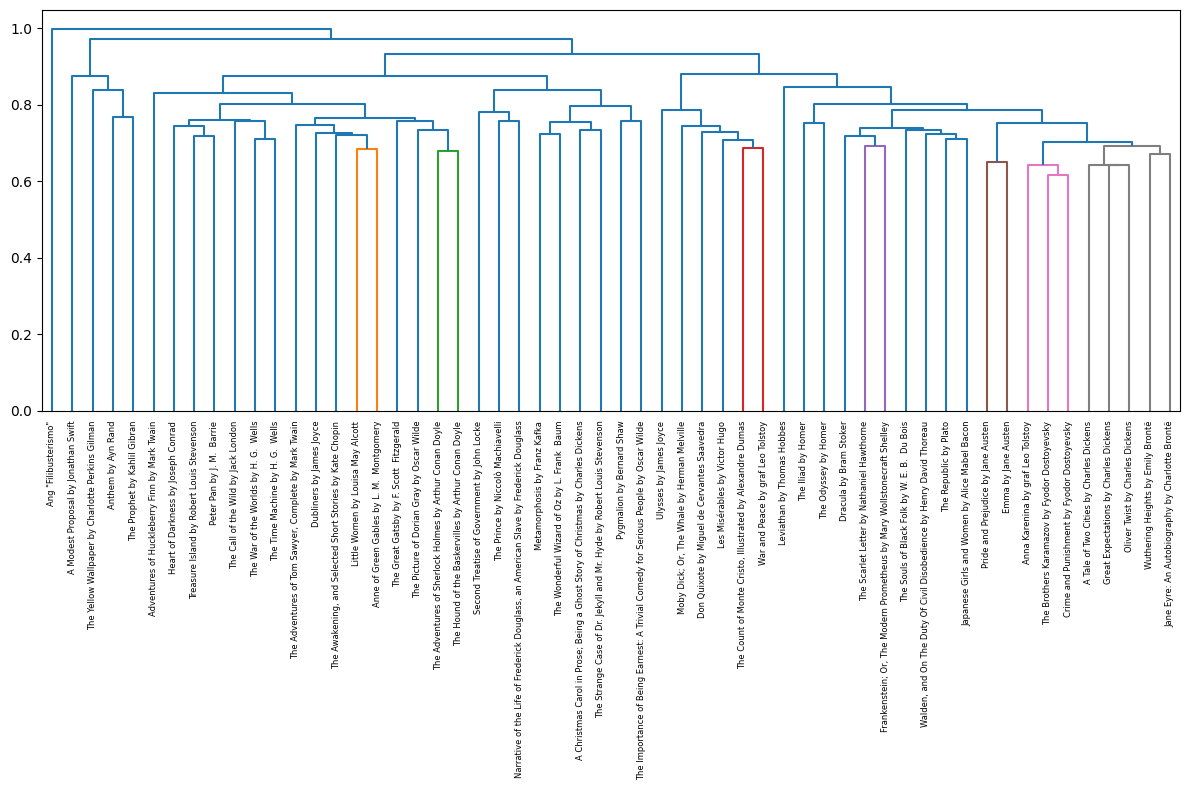

In [20]:
mergings = linkage(squareform(dists), method='complete')

plt.figure(figsize = (12,8))
dendrogram(mergings,
           labels = list(book_tokens.keys()),
           leaf_rotation = 90,
           leaf_font_size = 6);

plt.tight_layout()
plt.savefig('../images/dendogram_complete_jaccard.png', transparent=False, facecolor='white', dpi = 150);

**Bonus Material** Jaccard Similarity does not account for the frequency that each word is used, only whether or not it is used.

We might be better off using the **cosine similarity** as a way to measure the similarity of two books.

Create a dataframe named `books_df` where each row corresponds to a book and each column corresponds to a word. It should count the number of times the word appears in that book (including zero). Use the book title as the index of this dataframe.

In [27]:
def tokenize_book2(book):
    # Split the book into words and count them
    return Counter(book.lower().split())

In [28]:
def tokenize_book2(book):
    # Split the book into words and count them
    return Counter(book.lower().split())

book_tokens2 = {}
for title, book in books.items():
    book_tokens2[title] = tokenize_book(book)

books_df = pd.DataFrame.from_dict(book_tokens2, orient='index').fillna(0).astype(int)
books_df

ValueError: invalid literal for int() with base 10: 'resistance'